In [1]:
####################################################
## Hurricane Ida Analysis                         ##
## @brett | 09-05-2021                            ##
####################################################

# Getting Data Ready

In [2]:
from matplotlib import pyplot

In [3]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib import pyplot


# Change some settings
pd.options.display.max_rows = 999

# Import Data
last_year = pd.read_csv('./../data/Calls_for_service_2020.csv')
this_year = pd.read_csv('./../data/Calls_for_service_2021.csv')

# Merge into one dataset
data = this_year.append(last_year).reset_index().drop('index',axis=1)

# Read New Orleans Shapefile available here (https://portal-nolagis.opendata.arcgis.com/datasets/neighborhood-statistical-areas/explore)
no = gpd.read_file('./../data/Neighborhood_Statistical_Areas.zip')
no = no.to_crs(epsg=4326)

# Constants
CRS = "EPSG:4326"

In [4]:
def get_latlon(s, lat=True):
    '''
    Helper Function to extract lat/lon from string
    '''
    try:
        t = s.replace('(','').replace(')','').split(' ')
        x = t[1]
        y = t[2]
        if(lat):
            return(float(x))
        else:
            return(float(y))
    except:
        return(None)

In [5]:
data['lat'] = data.Location.apply(lambda x: get_latlon(x, True))
data['lon'] = data.Location.apply(lambda x: get_latlon(x, False))

In [6]:
geometry = gpd.points_from_xy(data.lat, data.lon, crs=CRS)
geo_df = gpd.GeoDataFrame(data, crs=CRS, geometry=geometry)

In [7]:
import censusdata
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2015)

{'Mississippi': censusgeo((('state', '28'),)),
 'Missouri': censusgeo((('state', '29'),)),
 'Montana': censusgeo((('state', '30'),)),
 'Nebraska': censusgeo((('state', '31'),)),
 'Nevada': censusgeo((('state', '32'),)),
 'New Hampshire': censusgeo((('state', '33'),)),
 'New Jersey': censusgeo((('state', '34'),)),
 'New Mexico': censusgeo((('state', '35'),)),
 'New York': censusgeo((('state', '36'),)),
 'North Carolina': censusgeo((('state', '37'),)),
 'North Dakota': censusgeo((('state', '38'),)),
 'Ohio': censusgeo((('state', '39'),)),
 'Oklahoma': censusgeo((('state', '40'),)),
 'Oregon': censusgeo((('state', '41'),)),
 'Pennsylvania': censusgeo((('state', '42'),)),
 'Rhode Island': censusgeo((('state', '44'),)),
 'South Carolina': censusgeo((('state', '45'),)),
 'South Dakota': censusgeo((('state', '46'),)),
 'Tennessee': censusgeo((('state', '47'),)),
 'Texas': censusgeo((('state', '48'),)),
 'Vermont': censusgeo((('state', '50'),)),
 'Utah': censusgeo((('state', '49'),)),
 'Virgin

In [8]:
# This cleans the date, if there is no date there, I fill in a date from 1900 so that I can easily filter it out
def clean_date(s):
    try:
        return(datetime.strptime(s,'%m/%d/%Y %I:%M:%S %p'))
    except:
        return(None)

In [9]:
# Let's clean up some of these fun timestamps
data['DateCreate'] = data['TimeCreate'].apply(lambda x: datetime.strptime(x[:10],'%m/%d/%Y'))
data['TimeCreate'] = data['TimeCreate'].apply(lambda x: clean_date(x))
data['TimeDispatch'] = data['TimeDispatch'].apply(lambda x: clean_date(x))
data['TimeArrive'] = data['TimeArrive'].apply(lambda x: clean_date(x))
data['TimeClosed'] = data['TimeClosed'].apply(lambda x: clean_date(x))

# Let's start exploring

First off, going to look at overall counts and the changes that happened

In [10]:
day_counts = data[['DateCreate', 'TimeCreate']].groupby('DateCreate').count().reset_index()
day_counts.columns = ['date', 'count']

[Text(0, 0.5, 'count of incidents')]

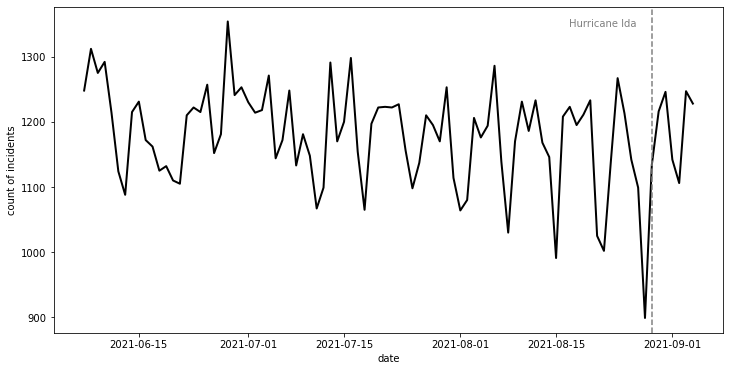

In [11]:
fig,ax = plt.subplots(figsize = (12,6))
sns.lineplot(x="date", y="count",
             data=day_counts[-90:], color='black', linewidth=2)
ax.axvline(datetime.strptime('20210829','%Y%m%d'), color='grey', linestyle='--')
ax.text(0.82, 0.95,'Hurricane Ida',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, color='grey')
ax.set(ylabel='count of incidents')

Looks like it is an anomaly for how low it is on the day before the hurricane...I wonder why. how does that fit into the distribution?

In [14]:
day_counts['count'].describe()

count     613.000000
mean     1191.401305
std        91.173981
min       899.000000
25%      1133.000000
50%      1188.000000
75%      1248.000000
max      1534.000000
Name: count, dtype: float64

In [17]:
# check z-score
z = (899-1191.4)/91.173981
z

-3.2070553110980216

[Text(0.5, 0, 'count of daily incidents')]

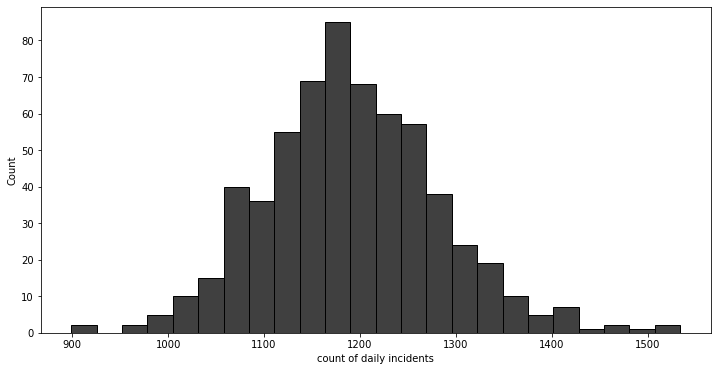

In [51]:
fig,ax = plt.subplots(figsize = (12,6))
sns.histplot(day_counts['count'], color='black')
ax.set(xlabel='count of daily incidents')

So the day before the Hurricane saw the lowest amount of incidents ever. Why do we think that is? Could it be that the policeforce was busy doing something else to help prep the community?

[Text(0, 0.5, 'count of incidents'), Text(0.5, 0, 'date')]

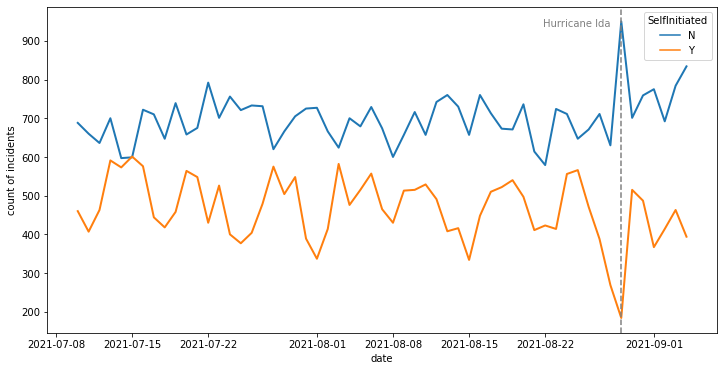

In [52]:
s = data[data.TimeCreate>='2021-07-10']
types = s[['DateCreate', 'SelfInitiated', 'TimeClosed']].groupby(['DateCreate', 'SelfInitiated']).count().reset_index()
fig,ax = plt.subplots(figsize = (12,6))
sns.lineplot(data=types, x="DateCreate", y="TimeClosed", hue="SelfInitiated", linewidth=2)
ax.axvline(datetime.strptime('20210829','%Y%m%d'), color='grey', linestyle='--')
ax.text(0.79, 0.95,'Hurricane Ida',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, color='grey')
ax.set(ylabel='count of incidents', xlabel='date')

Sure looks like it. The number of self-initiatied incidents went down significantly.

In [26]:
data['DispositionText']

0         Necessary Action Taken
1         Necessary Action Taken
2               REPORT TO FOLLOW
3               REPORT TO FOLLOW
4                      UNFOUNDED
                   ...          
730324    Necessary Action Taken
730325    Necessary Action Taken
730326    Necessary Action Taken
730327           GONE ON ARRIVAL
730328    Necessary Action Taken
Name: DispositionText, Length: 730329, dtype: object

[Text(0, 0.5, 'count of incidents'), Text(0.5, 0, 'date')]

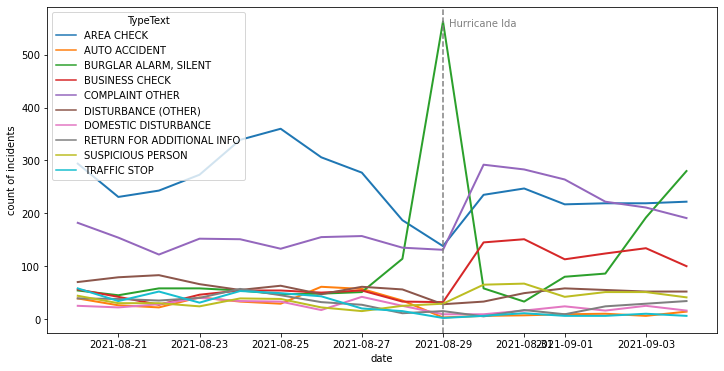

In [18]:
s = data[data.TimeCreate>='2021-08-20']
types = s[['DateCreate', 'TypeText', 'TimeClosed']].groupby(['DateCreate', 'TypeText']).count().reset_index()
fig,ax = plt.subplots(figsize = (12,6))
sns.lineplot(data=types[types.TypeText.isin(['AREA CHECK','COMPLAINT OTHER','DISTURBANCE (OTHER)','BUSINESS CHECK','BURGLAR ALARM, SILENT','RETURN FOR ADDITIONAL INFO','TRAFFIC STOP','SUSPICIOUS PERSON','AUTO ACCIDENT','DOMESTIC DISTURBANCE'])], x="DateCreate", y="TimeClosed", hue="TypeText", linewidth=2)
ax.axvline(datetime.strptime('20210829','%Y%m%d'), color='grey', linestyle='--')
ax.text(0.65, 0.95,'Hurricane Ida',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, color='grey')
ax.set(ylabel='count of incidents', xlabel='date')

Meanwhile, burglar alarms started to account for a rise. Also, while there was a spike, the upward trend continued.

We should probably also look at it by census tract

In [54]:
j = gpd.sjoin(geo_df, no, how="left", op='intersects')

[Text(0, 0.5, 'count of incidents'), Text(0.5, 0, 'date')]

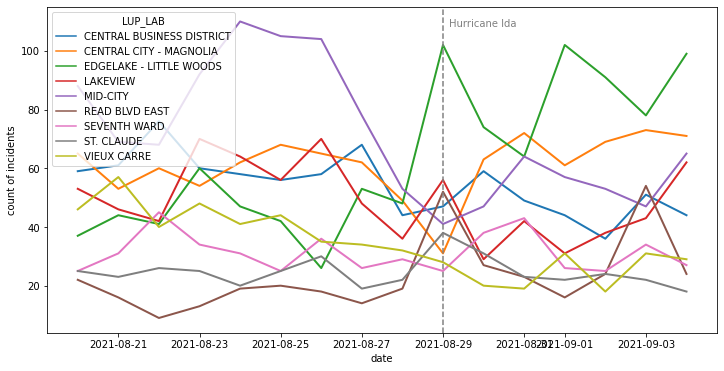

In [55]:
s = j[j.TimeCreate>='2021-08-20']
types = s[['DateCreate', 'LUP_LAB', 'TimeClosed']].groupby(['DateCreate', 'LUP_LAB']).count().reset_index()
fig,ax = plt.subplots(figsize = (12,6))
sns.lineplot(data=types[types.LUP_LAB.isin(['EDGELAKE - LITTLE WOODS', 'LAKEVIEW', 'READ BLVD EAST', 'CENTRAL BUSINESS DISTRICT', 'MID-CITY', 'ST. CLAUDE', 'CENTRAL CITY - MAGNOLIA', 'VIEUX CARRE', 'SEVENTH WARD'])], x="DateCreate", y="TimeClosed", hue="LUP_LAB", linewidth=2)
ax.axvline(datetime.strptime('20210829','%Y%m%d'), color='grey', linestyle='--')
ax.text(0.65, 0.95,'Hurricane Ida',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, color='grey')
ax.set(ylabel='count of incidents', xlabel='date')

# Building a model

In [56]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [57]:
day_counts.quantile(0.01)

count    989.24
Name: 0.01, dtype: float64

In [58]:
day_counts.min()

date     2020-01-01 00:00:00
count                    899
dtype: object

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

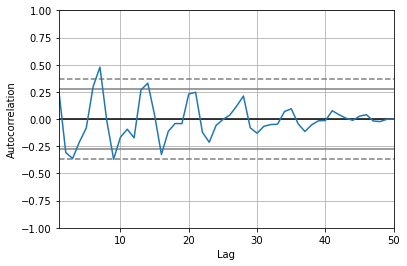

In [59]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(day_counts['count'][-50:])

In [60]:
# I am only going to establish a 90 day view to inform the model
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
        
adfuller_test(day_counts['count'][-90:])

ADF Test Statistic : -3.698781851890927
p-value : 0.004130321144787197
#Lags Used : 11
Number of Observations : 78


the data is stationary, so don't need to do any shifting there

In [61]:
# Test dataset here
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(day_counts['count'][-90:],order=(7,1,1))
model_fit=model.fit()
model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.60677D+00    |proj g|=  5.71111D-02

At iterate    5    f=  5.60420D+00    |proj g|=  4.04885D-03

At iterate   10    f=  5.60391D+00    |proj g|=  4.69988D-03

At iterate   15    f=  5.60334D+00    |proj g|=  1.00089D-03

At iterate   20    f=  5.60327D+00    |proj g|=  4.16556D-04


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.



At iterate   25    f=  5.60327D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     26     30      1     0     0   8.882D-08   5.603D+00
  F =   5.6032700904815114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:1476: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(np.r_[1, self.maparams]) ** -1


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.count   No. Observations:                   89
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -498.691
Method:                       css-mle   S.D. of innovations             64.756
Date:                Tue, 07 Sep 2021   AIC                           1017.382
Time:                        21:15:34   BIC                           1042.268
Sample:                             1   HQIC                          1027.413
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4312      2.031     -0.212      0.832      -4.412       3.549
ar.L1.D.count    -0.0701      0.360     -0.194      0.846      -0.776       0.636
ar.L2.D.count    -0.4152      0.219     -1.897      0.058      -0.844       0.014
ar.L3.D.count    -0.1690      0.278     -0.607      0.544      -0.715       0.377
ar.L4.D.count    -0.2319      0.229     -1.011      0.312      -0.682       0.218
ar.L5.D.count    -0.2113      0.224     -0.943      0.346      -0.650       0.228
ar.L6.D.count     0.1387      0.219      0.632      0.528      -0.292       0.569
ar.L7.D.count     0.2042      0.127      1.603      0.109      -0.045       0.454
ma.L1.D.count    -0.4918      0.354     -1.388      0.165      -1.186       0.203
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6084           -0.8821j            1.0716           -0.1539
AR.2            0.6084           +0.8821j            1.0716            0.1539
AR.3            1.5256           -0.0000j            1.5256           -0.0000
AR.4           -0.3428           -1.0755j            1.1288           -0.2991
AR.5           -0.3428           +1.0755j            1.1288            0.2991
AR.6           -1.3680           -0.5679j            1.4812           -0.4374
AR.7           -1.3680           +0.5679j            1.4812            0.4374
MA.1            2.0336           +0.0000j            2.0336            0.0000
-----------------------------------------------------------------------------
"""

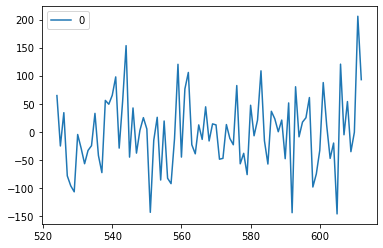

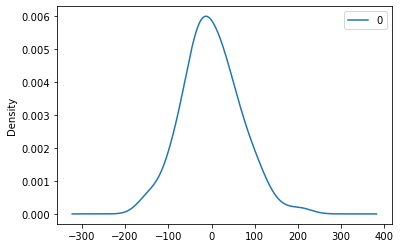

In [62]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

In [63]:
day_counts['forecast']=model_fit.predict(start = 10, end = 100, dynamic= True)